# Problem Formulation

This experiment investigates binary classification in a scenario with missing side information, where a decision-maker's preference can influence the outcome.

- **Features ($X$)**: A 2D feature vector in $\mathbb{R}^2$.
- **Label ($Y$)**: A binary label in $\{-1, +1\}$, representing a primary category (e.g., university branch allocation: $+1$ for Computer Science, $-1$ for Electrical Engineering).
- **Side Information ($Z$)**: A binary variable in $\{-1, +1\}$ that provides additional context (e.g., qualifying exam subject: $+1$ for Maths, $-1$ for Physics). This information is only sometimes available.
- **Preference ($U$)**: A binary variable in $\{-1, +1\}$ indicating the candidate's preferred outcome (e.g., their desired branch). This is always known.

The joint probability distribution $P(Y, Z, U)$ is parameterized by a correlation factor $\rho$ that controls the alignment between the true label $Y$ and the candidate's preference $U$. The feature vector $X$ is drawn from one of eight Gaussian distributions, conditioned on the combined values of $(Y, Z, U)$.

The core challenge is to build a classifier that can handle cases where the side information $Z$ is missing. We will compare two models that address this problem differently, especially when the candidate's preference $U$ is taken into account. The goal is to determine which model performs better across varying levels of $Y-U$ correlation ($\rho$) and $Z$ observability ($p_o$).

# Proposed Solution

- **High-Level Strategy:** Implement and compare two PyTorch-based models for binary classification under conditions of randomly missing side information ($Z$). The comparison will be performed across a grid of parameters for $\rho$ (correlation between $Y$ and $U$) and $p_o$ (observability of $Z$).
- **Models:**
    1.  **Model 1 (Complex):** When $Z$ is observed, this model uses a soft-max or soft-min function to combine the outputs of two linear models, $f_w(x, +1)$ and $f_w(x, -1)$, guided by the user's preference $U$. When $Z$ is unobserved, it uses a weighted average of the two linear models.
    2.  **Model 2 (Simple):** When $Z$ is observed, this model directly uses the output of the linear model $f_w(x, z)$. When $Z$ is unobserved, it behaves identically to Model 1.
- **Workflow:**
    1.  **Data Generation:** Create a function to generate training and testing datasets based on the specified joint and conditional distributions. This function will take $\rho$ and $p_o$ as inputs.
    2.  **Model Implementation:** Define a PyTorch `nn.Module` that can represent both models, with a flag to switch between the complex and simple forward passes.
    3.  **Training and Evaluation:** Develop functions to train the models using logistic loss and evaluate them using a 0-1 loss (accuracy).
    4.  **Experiment Loop:** Iterate through all combinations of $\rho$ and $p_o$. In each iteration, generate data, train both models, and record their test risks.
    5.  **Results:** Display the final results in a formatted table, highlighting which model performed better for each parameter combination.

# ⚙️ Implementation

### ⚙️ Block 0: Configuration Block

This block contains all the configurable parameters for the experiment. Centralizing these parameters makes the notebook easier to understand, reuse, and modify. We define hyperparameters for the models, data generation settings, and other constants.

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Experiment parameters
N_TRAIN = 2000
N_TEST = 1000
RHO_VALUES = np.linspace(0.0, 1.0, 5)  # 5 values for rho
P_O_VALUES = np.linspace(0.0, 1.0, 5)  # 5 values for p_o

# Model hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 64
TAU = 0.5  # Temperature for soft-max/min

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

### 📦 Dataset

This section handles all data-related steps, including the generation of the dataset based on the problem's specifications.

**What:** The `generate_data` function creates a synthetic dataset for the experiment.
**Why:** We need a controlled way to generate data that reflects the properties of our problem, including the correlation $\rho$ and the observability of side information $p_o$.
**How:**
1.  **Constructing the Joint Distribution $P(Y, Z, U)$:**
    The distribution is built from the ground up using the law of total probability. We are given:
    -   $P(Y=1) = 0.5$ and $P(U=1) = 0.5$.
    -   Conditional probabilities of $Z$ given $Y$: $P(Z=1|Y=1) = 0.8$ and $P(Z=1|Y=-1) = 0.2$. This establishes a correlation between $Y$ and $Z$.
    -   The correlation between $Y$ and $U$ is controlled by $\rho$: $P(Y=1, U=1) = 0.25 + \rho \times 0.25$.
    
    From these, we derive the full joint probability for each of the 8 combinations of $(y, z, u) \in \{-1, 1\}^3$. The probability of a specific combination is given by:
    $P(Y=y, Z=z, U=u) = P(Z=z|Y=y) \times P(Y=y, U=u)$
    
    We first calculate the four probabilities for the pairs $(Y, U)$ using $\rho$. For example, $P(Y=1, U=-1) = P(Y=1) - P(Y=1, U=1)$. Then, for each of these, we multiply by the conditional probability of $Z$. For instance, to get $P(Y=1, Z=1, U=1)$, we compute $P(Z=1|Y=1) \times P(Y=1, U=1)$. This process is repeated for all 8 combinations, and the resulting probabilities are normalized to ensure they sum to 1.

2.  **Gaussian Means:** It defines the means for the 8 Gaussian distributions, placing them on the unit circle. Each mean corresponds to one of the 8 combinations of $(Y, Z, U)$.
3.  **Sampling:** It samples $(Y, Z, U)$ triplets from the constructed joint distribution.
4.  **Feature Generation:** For each triplet, it samples the feature vector $X$ from the corresponding Gaussian distribution with a diagonal covariance matrix.
5.  **Missingness:** It randomly sets the $Z$ values to 0 (representing "missing") with probability $1 - p_o$.
6.  **Tensor Conversion:** The final dataset is converted to PyTorch tensors.

In [43]:
def generate_data(n_samples, p_o):
    """
    Generates a dataset for the experiment.
    
    Args:
        n_samples (int): The number of samples to generate.
        p_o (float): The probability of observing Z.

    Returns:
        A tuple of torch tensors: (X, Y, Z, U, Z_observed_mask)
    """
    # Sample (Y, Z) pairs from the joint distribution
    yz_pairs = list(P_YZ.keys())
    probabilities = list(P_YZ.values())
    indices = np.random.choice(len(yz_pairs), size=n_samples, p=probabilities)
    yz = torch.tensor([yz_pairs[i] for i in indices], dtype=torch.float32)
    Y = yz[:, 0]
    Z = yz[:, 1]

    # Sample X from the conditional Gaussian distribution
    X = torch.zeros(n_samples, 2)
    for i in range(n_samples):
        mean = MEANS[(Y[i].item(), Z[i].item())]
        X[i] = torch.distributions.MultivariateNormal(mean, COV_MATRIX).sample()

    # Compute the preference function U
    # U = torch.sign(torch.sin(ALPHA * (X[:, 0] + X[:, 1])))
    # U[U == 0] = 1 # Set sign(0) to 1
    U = torch.ones(n_samples)

    # Determine which Z values are observed based on p_o
    z_observed_mask = (torch.rand(n_samples) < p_o)

    return X, Y, Z, U, z_observed_mask

### 🧱 Architecture

This section defines the architecture of the classification models.

**What:** The `StrategicModel` class implements the core logic for both models. It's a PyTorch `nn.Module`.
**Why:** A single class is used to encapsulate the shared linear layer and the different forward pass logics for Model 1 (complex) and Model 2 (simple). This promotes code reuse.
**How:**
-   **Initialization:** It creates a linear layer for $f_w(x, z) = w_0 + w_1 x_1 + w_2 x_2 + w_3 z$ and a parameter `log_lambda_sq` for the weighted average $g_{w, \lambda}(x)$.
-   **`f_w`:** A helper method that computes the score from the linear layer.
-   **`g_w_lambda`:** Computes the score for unobserved $Z$ by taking a weighted average: 
    $g_{w, \lambda}(x) = \frac{\lambda^2}{1+\lambda^2} f_w(x, -1) + \frac{1}{1+\lambda^2} f_w(x, +1)$.
-   **`forward`:** This is the main method.
    -   It first identifies which samples have observed $Z$ and which do not.
    -   For unobserved $Z$, both models compute the score using $g_{w, \lambda}$.
    -   For observed $Z$:
        -   **Model 1 (complex):** If `use_strategic=True`, it applies the soft-max/soft-min logic based on the preference $U$. The soft-max is defined as:
            $\text{score} = \frac{g \cdot e^{g/\tau} + f \cdot e^{f/\tau}}{e^{g/\tau} + e^{f/\tau}}$
        -   **Model 2 (simple):** If `use_strategic=False`, it directly computes the score using $f_w(x, z)$.
    -   It combines the scores from the observed and unobserved batches to produce the final output.

In [44]:
class StrategicClassifier(torch.nn.Module):
    def __init__(self, use_complex_score):
        super().__init__()
        self.use_complex_score = use_complex_score
        
        # Define f_w as a small neural network (2-layer MLP)
        self.f_w_net = torch.nn.Sequential(
            torch.nn.Linear(3, 16), # Input is x (2D) + z (1D) = 3D
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1)
        )
        
        # Parameter lambda for g_{w,lambda}
        self.log_lambda_sq = torch.nn.Parameter(torch.tensor(0.0)) # log(lambda^2) for stability

    def f_w(self, x, z):
        """Computes the score f_w(x, z) using the neural network."""
        # Concatenate x and z to create the input for the network
        z_reshaped = z.unsqueeze(1)
        net_input = torch.cat((x, z_reshaped), dim=1)
        return self.f_w_net(net_input).squeeze(-1)

    def g_w_lambda(self, x):
        """Computes the score g_{w,lambda}(x)."""
        lambda_sq = torch.exp(self.log_lambda_sq)
        weight_neg = lambda_sq / (1 + lambda_sq)
        weight_pos = 1 / (1 + lambda_sq)
        return weight_neg * self.f_w(x, -torch.ones(x.shape[0])) + \
               weight_pos * self.f_w(x, torch.ones(x.shape[0]))

    def forward(self, x, z, u, z_observed_mask):
        """Computes the final score for prediction."""
        score_g = self.g_w_lambda(x)
        
        # For samples where Z is not observed, the score is g
        final_score = score_g.clone()

        # For samples where Z is observed
        if torch.any(z_observed_mask):
            x_obs = x[z_observed_mask]
            z_obs = z[z_observed_mask]
            u_obs = u[z_observed_mask]
            
            score_f = self.f_w(x_obs, z_obs)

            if self.use_complex_score:
                score_g_obs = score_g[z_observed_mask]
                
                # Soft-max for u = +1
                mask_u_pos = (u_obs == 1)
                if torch.any(mask_u_pos):
                    s_g = score_g_obs[mask_u_pos]
                    s_f = score_f[mask_u_pos]
                    exp_g = torch.exp(s_g / TAU)
                    exp_f = torch.exp(s_f / TAU)
                    final_score[z_observed_mask][mask_u_pos] = (s_g * exp_g + s_f * exp_f) / (exp_g + exp_f)

                # Soft-min for u = -1
                mask_u_neg = (u_obs == -1)
                if torch.any(mask_u_neg):
                    s_g = score_g_obs[mask_u_neg]
                    s_f = score_f[mask_u_neg]
                    exp_g = torch.exp(-s_g / TAU)
                    exp_f = torch.exp(-s_f / TAU)
                    final_score[z_observed_mask][mask_u_neg] = (s_g * exp_g + s_f * exp_f) / (exp_g + exp_f)
            else: # Simple score setting
                final_score[z_observed_mask] = score_f
                
        return final_score

### 🧪 Experiment

This section contains the functions for training and evaluating the models.

**What:** The `train_model` and `evaluate_model` functions define the experimental loop.
**Why:** Separating the training and evaluation logic into functions makes the main experimental loop cleaner and more readable.
**How:**
-   **`train_model`:**
    -   Takes the model, data, and hyperparameters as input.
    -   Uses the Adam optimizer and logistic loss (`BCEWithLogitsLoss`).
    -   Iterates through the data for a fixed number of epochs, updating the model weights.
-   **`evaluate_model`:**
    -   Takes the trained model and test data as input.
    -   Computes the model's predictions (scores).
    -   Calculates the 0-1 loss (risk) by comparing the sign of the scores to the true labels: $\frac{1}{N} \sum_{i=1}^N \mathbb{I}(\text{sign}(\text{score}_i) \neq y_i)$.
    -   Returns the average risk.

In [45]:
def train_model(model, X, Y, Z, U, z_observed_mask):
    """Trains the classifier."""
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    dataset = torch.utils.data.TensorDataset(X, Y, Z, U, z_observed_mask)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(N_EPOCHS):
        for x_batch, y_batch, z_batch, u_batch, z_obs_mask_batch in dataloader:
            optimizer.zero_grad()
            scores = model(x_batch, z_batch, u_batch, z_obs_mask_batch)
            loss = loss_fn(scores, (y_batch + 1) / 2) # BCEWithLogitsLoss expects labels in [0, 1]
            loss.backward()
            optimizer.step()

def evaluate_model(model, X_test, Y_test, Z_test, U_test, z_observed_mask_test):
    """Evaluates the model and returns the risk (0-1 loss)."""
    with torch.no_grad():
        scores = model(X_test, Z_test, U_test, z_observed_mask_test)
        predictions = torch.sign(scores)
        risk = torch.mean((predictions != Y_test).float())
    return risk.item()

# --- Main Experiment Loop ---
risks_complex = []
risks_simple = []

for p_o in tqdm(P_O_VALUES, desc="Running Experiments"):
    # Generate training and test data with the same p_o
    X_train, Y_train, Z_train, U_train, z_obs_mask_train = generate_data(N_SAMPLES_TRAIN, p_o)
    X_test, Y_test, Z_test, U_test, z_obs_mask_test = generate_data(N_SAMPLES_TEST, p_o)
    
    # --- Model 1: Complex Score Classifier ---
    model_complex = StrategicClassifier(use_complex_score=True)
    train_model(model_complex, X_train, Y_train, Z_train, U_train, z_obs_mask_train)
    
    # Evaluate on test data with the same p_o
    risk_complex = evaluate_model(model_complex, X_test, Y_test, Z_test, U_test, z_obs_mask_test)
    risks_complex.append(risk_complex)

    # --- Model 2: Simple Score Classifier ---
    model_simple = StrategicClassifier(use_complex_score=False)
    train_model(model_simple, X_train, Y_train, Z_train, U_train, z_obs_mask_train)

    # Evaluate on test data with the same p_o
    risk_simple = evaluate_model(model_simple, X_test, Y_test, Z_test, U_test, z_obs_mask_test)
    risks_simple.append(risk_simple)

Running Experiments:   0%|          | 0/11 [00:00<?, ?it/s]

### 🔍 Inspection & Visualization Block

In this block, we visualize the results of our experiment. We will plot the risks of the complex score and simple score models as a function of the observation probability \( p_o \). This plot is the key output of our analysis, as it allows for a direct comparison of the two models under different conditions.

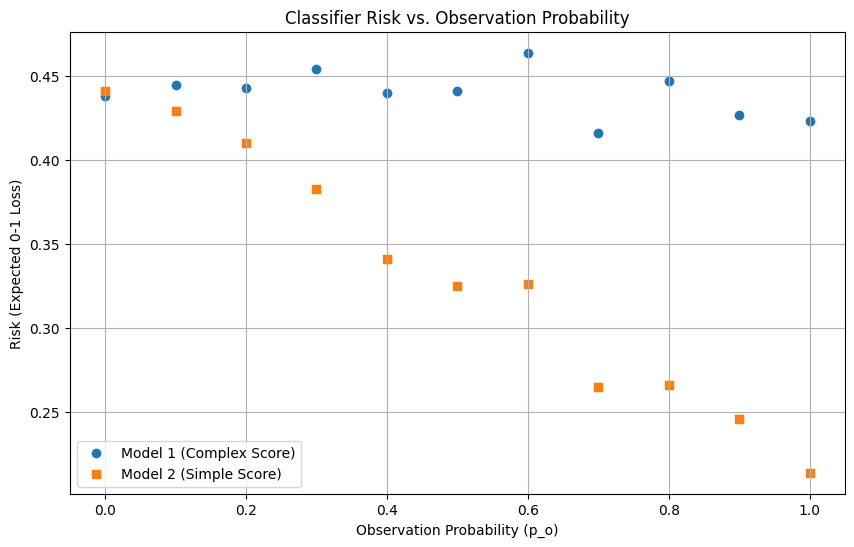

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(P_O_VALUES, risks_complex, marker='o', label='Model 1 (Complex Score)')
plt.scatter(P_O_VALUES, risks_simple, marker='s', label='Model 2 (Simple Score)')
plt.xlabel('Observation Probability (p_o)')
plt.ylabel('Risk (Expected 0-1 Loss)')
plt.title('Classifier Risk vs. Observation Probability')
plt.legend()
plt.grid(True)
plt.show()